In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode

#

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
#

import xgboost as xgb
import lightgbm as lgt

#

import warnings
warnings.filterwarnings('ignore')
import re

In [2]:
df_tr=pd.read_csv('train.csv')
df_te=pd.read_csv('test.csv')

In [3]:
df_te['Survived'] = np.nan
complete = pd.concat([df_tr, df_te])

In [4]:
complete.isna().sum().sort_values(ascending=False)

Cabin          1014
Survived        418
Age             263
Embarked          2
Fare              1
Ticket            0
Parch             0
SibSp             0
Sex               0
Name              0
Pclass            0
PassengerId       0
dtype: int64

In [5]:
complete['Embarked'].fillna(mode(complete['Embarked']), inplace=True)
print(complete['Embarked'].isna().sum())

0


In [6]:
complete['Embarked']=complete['Embarked'].map({'S' : 0, 'C' : 1, 'Q' : 2})
complete['Embarked'].value_counts(normalize=True)

0    0.699771
1    0.206264
2    0.093965
Name: Embarked, dtype: float64

In [7]:
complete['Sex']=complete['Sex'].map({'male': 0, 'female':1})
complete['Sex'].value_counts(normalize=True)

0    0.644003
1    0.355997
Name: Sex, dtype: float64

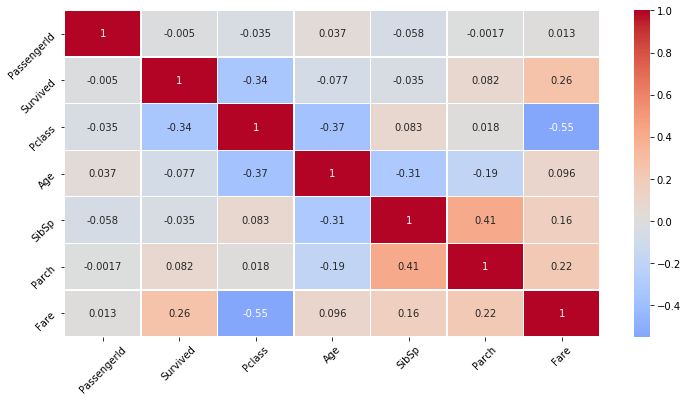

In [8]:
corrmat=df_tr.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corrmat, annot=True, linewidths=0.2,cmap='coolwarm', center=0)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [9]:
complete['Age'] = complete.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

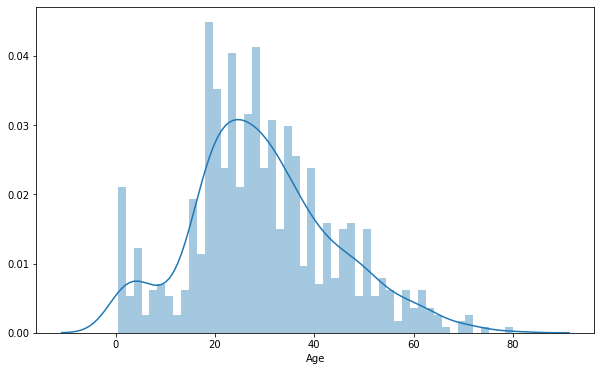

In [10]:
plt.subplots(figsize=(10, 6))
sns.distplot(df_tr['Age'],bins=50)
plt.show()

In [11]:
complete['Fare'] = complete.groupby("Pclass")['Fare'].transform(lambda x: x.fillna(x.median()))

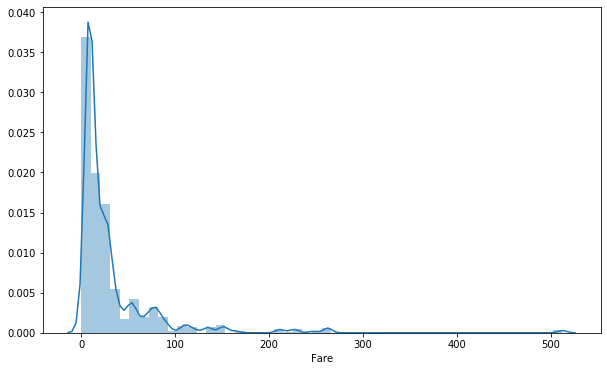

In [12]:
plt.subplots(figsize=(10, 6))
sns.distplot(df_tr['Fare'],bins=50)
plt.show()

In [13]:
complete['Cabin'] = complete['Cabin'].fillna('U')

In [14]:
complete.isnull().sum().sort_values(ascending = False)

Survived       418
Embarked         0
Cabin            0
Fare             0
Ticket           0
Parch            0
SibSp            0
Age              0
Sex              0
Name             0
Pclass           0
PassengerId      0
dtype: int64

In [15]:
complete['Cabin'] = complete['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())

In [16]:
complete['Cabin'].unique().tolist()

['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T']

In [17]:
cabin_category = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8, 'U':9}
complete['Cabin'] = complete['Cabin'].map(cabin_category)
complete['Cabin'].unique().tolist()

[9, 3, 5, 7, 4, 1, 2, 6, 8]

In [18]:
complete['Title'] = complete['Name'].str.extract(' ([A-Za-z]+)\.', expand = False)

In [19]:
complete['Title'].unique().tolist()

['Mr',
 'Mrs',
 'Miss',
 'Master',
 'Don',
 'Rev',
 'Dr',
 'Mme',
 'Ms',
 'Major',
 'Lady',
 'Sir',
 'Mlle',
 'Col',
 'Capt',
 'Countess',
 'Jonkheer',
 'Dona']

In [20]:
complete['Title'].value_counts(normalize = True) * 100

Mr          57.830405
Miss        19.862490
Mrs         15.049656
Master       4.660046
Dr           0.611154
Rev          0.611154
Col          0.305577
Ms           0.152788
Mlle         0.152788
Major        0.152788
Dona         0.076394
Lady         0.076394
Jonkheer     0.076394
Mme          0.076394
Don          0.076394
Sir          0.076394
Countess     0.076394
Capt         0.076394
Name: Title, dtype: float64

In [21]:
complete['Title'] = complete['Title'].replace(['Rev', 'Dr', 'Col', 'Ms', 'Mlle', 'Major', 'Countess', 
                                       'Capt', 'Dona', 'Jonkheer', 'Lady', 'Sir', 'Mme', 'Don'], 'Other')

In [22]:
title_category = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Other':5}
complete['Title'] = complete['Title'].map(title_category)
complete['Title'].unique().tolist()

[1, 3, 2, 4, 5]

In [23]:
complete['Title'].value_counts(normalize = True) * 100

1    57.830405
2    19.862490
3    15.049656
4     4.660046
5     2.597403
Name: Title, dtype: float64

In [24]:
complete['FamilySize'] = complete['SibSp'] + complete['Parch'] + 1

In [25]:
complete.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,9,0,1,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,3,1,3,2
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,9,0,2,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,3,0,3,2
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,9,0,1,1


In [26]:
complete = complete.drop(['Name', 'SibSp', 'Parch', 'Ticket'], axis = 1)

In [27]:
complete.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,1,0.0,3,0,22.0,7.2500,9,0,1,2
1,2,1.0,1,1,38.0,71.2833,3,1,3,2
2,3,1.0,3,1,26.0,7.9250,9,0,2,1
3,4,1.0,1,1,35.0,53.1000,3,0,3,2
4,5,0.0,3,0,35.0,8.0500,9,0,1,1


In [28]:
df_te = complete[complete['Survived'].isna()].drop(['Survived'], axis = 1)

In [29]:
df_tr = complete[complete['Survived'].notna()]

In [30]:
df_tr['Survived'] = df_tr['Survived'].astype(np.int64)

In [31]:
df_te

,PassengerId,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,892,3,0,34.5,7.8292,9,2,1,1
1,893,3,1,47.0,7.0000,9,0,3,2
2,894,2,0,62.0,9.6875,9,2,1,1
3,895,3,0,27.0,8.6625,9,0,1,1
4,896,3,1,22.0,12.2875,9,0,3,3
...,...,...,...,...,...,...,...,...,...
413,1305,3,0,25.0,8.0500,9,0,1,1
414,1306,1,1,39.0,108.9000,3,1,5,1
415,1307,3,0,38.5,7.2500,9,0,1,1
416,1308,3,0,25.0,8.0500,9,0,1,1


In [32]:
df_tr

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,1,0,3,0,22.0,7.2500,9,0,1,2
1,2,1,1,1,38.0,71.2833,3,1,3,2
2,3,1,3,1,26.0,7.9250,9,0,2,1
3,4,1,1,1,35.0,53.1000,3,0,3,2
4,5,0,3,0,35.0,8.0500,9,0,1,1
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,13.0000,9,0,5,1
887,888,1,1,1,19.0,30.0000,2,0,2,1
888,889,0,3,1,22.0,23.4500,9,0,2,4
889,890,1,1,0,26.0,30.0000,3,1,1,1


In [33]:
df_tr.describe()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.352413,29.188182,32.204208,7.716049,0.361392,1.740741,1.904602
std,257.353842,0.486592,0.836071,0.477990,13.337887,49.693429,2.460739,0.635673,1.052077,1.613459
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,223.500000,0.000000,2.000000,0.000000,22.000000,7.910400,9.000000,0.000000,1.000000,1.000000
50%,446.000000,0.000000,3.000000,0.000000,26.000000,14.454200,9.000000,0.000000,1.000000,1.000000
75%,668.500000,1.000000,3.000000,1.000000,36.000000,31.000000,9.000000,1.000000,2.000000,2.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,512.329200,9.000000,2.000000,5.000000,11.000000


In [34]:
#df_tr['Fare']=np.log1p(df_tr['Fare'])
#df_te['Fare']=np.log1p(df_te['Fare'])
X=df_tr.drop(['Survived', 'PassengerId'], axis = 1)
#X=np.log1p(X)
scaler=StandardScaler()
#X=scaler.fit_transform(X)

#ct = ColumnTransformer([
#        ('somename', StandardScaler(), ['Fare'])
#   ], remainder='passthrough')

#X=ct.fit_transform(X)
#df_te=ct.fit_transform(df_te)
y=df_tr['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, test_size = 0.2, 
                                                    random_state = 42)
#X_train=scaler.fit_transform(X_train)
#X_test=scaler.transform(X_test)

In [35]:
logreg = LogisticRegression(max_iter = 10000)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
y_pred = logreg.predict(X_test)

In [37]:
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.7988826815642458
[[87 18]
 [18 56]]


In [38]:
kf = KFold(n_splits = 5, random_state = 42)

In [39]:
print(cross_val_score(logreg, X_test, y_test, cv = kf).mean())

0.8155555555555555


In [40]:
#randomForest = RandomForestClassifier(random_state = 2)
#param_grid = { 
#    'criterion' : ['gini', 'entropy'],
#    'n_estimators': [100, 300, 500],
#    'max_features': ['auto', 'log2'],
#    'max_depth' : [3, 5, 7]    
#}
#randomForest_CV = GridSearchCV(estimator = randomForest, param_grid = param_grid, cv = 5)
#randomForest_CV.fit(X_train, y_train)

In [41]:
#randomForest_CV.best_params_

In [42]:
randomForestFinalModel = RandomForestClassifier(random_state = 42, criterion = 'gini', max_depth = 7, max_features = 'auto', n_estimators = 300)

In [43]:
randomForestFinalModel.fit(X_train, y_train)
predictions = randomForestFinalModel.predict(X_test)

In [44]:
accuracy_score(y_test, predictions)

0.8379888268156425

In [45]:
df_te['Survived'] = randomForestFinalModel.predict(df_te.drop(['PassengerId'], axis = 1))

In [46]:
#df_te[['PassengerId', 'Survived']].to_csv('rf_submission.csv', index = False)

In [47]:
submission = pd.DataFrame({
        "PassengerId": df_te["PassengerId"],
        "Survived": df_te['Survived']
    })
submission.to_csv('submission.csv', index=False)